# Machine Learning Final Project Walkthrough
Andrew King (aking65), Jared Pangallozzi (jpangal2), Harshil Desai (hdesai5), Manan Aggarwal (maggarwal)

Github: https://github.com/jpangal2/ML_Final


# Outline and Deliverables

### Uncompleted Deliverables
<li>None</li>


### Completed Deliverables
<li>Cleaned and processed dataset</li>
<li>Working convolutional network trained on our dataset</li>
<li>Model performs better than random guessing on test set</li>
<li>Model performs better than 65% on the test set</li>
<li>Model performs better than 90% on the test set</li>
<li>Use two different architectures</li>
<li>Pretrain a model on another dataset (Imagenet)</li>
<li>Implement a model using PCA to compare with</li>









# Preliminaries

### What problem are we trying to solve?
In this project we attempted to create a model capable of performing facial recognition. That is, given an image of a face, the model is able to compare its similarity to faces it has already seen before and report which person it believes this new image to be a picture of.

Facial recognition has implications for a variety of tasks, including automatic tagging on social media, government surveillance, identity verification (unlocking an iPhone, getting through customs, accessing bank accounts), and even the potential to diagnose certain diseases (through facial analysis).

This problem entails a lot of the image processing methods that we talked about in lectures and in homeworks with regards to deep learning, specifically convolutional layers, pooling and input reshaping. We solved a multi-class classification problem in one of our homeworks, however it was on a simpler dataset than the one we used with many more training examples.

This problem is unique in that recent models have become so robust that their predictions have been relied upon by many powerful groups, such as banks, border & customs security organizations, and even judicial & law enforcement systems of governments. This means that misclassification by any model which we rely heavily upon could have disastrous implications on someone’s life. 

Certain facial recognition models have been shown to have racial bias in that they tend to misclassify people with darker skin more often. This has led to people being falsely accused of committing crimes. Although certain models perform extremely well on most cases, when we have unquestioning faith in them, people may be greatly impacted by our models’ mistakes.


### Dataset
For this project we are using the Yale Faces dataset. It contains 165 grayscale images of 15 subjects (11 images each) under facial expressions and lighting. This dataset is one of the most popular as a baseline for facial recognition tasks.

We chose this dataset primarily because we wanted to create a model that could learn from just a few training examples. Deep learning models tend to overfit the training data when they are not given enough examples and so we wanted to create a model that could achieve high performance on the test set with such a limited amount of data. To do this we used heavy data augmentation and pretraining.



# Preprocessing
Fortunately, this dataset does not have any missing entries and all imgaes are of the same dimensions which eliminated some of the usual preprocessing hurdles.

When we load an images, we transform it into a PyTorch tensor and normalize it to a known mean and standard deviation (0.5, 0.5). After that we apply the augmentations that will increase the amount of training data we have. These augmentations are:
<li>Random affine transformations</li>
<li>Random cropping</li>
<li>Random horizontal flipping</li>
<li>Random vertical flipping</li>
<li>Randomly erasing a portion of the image</li>
<li>Randomly warping perspective (random homography)</li>

We implemented this functionality in a custom PyTorch dataset class, so after we loaded our dataset we could use a dataloader on it. We chose the instances for our train, dev, test splits randomly within each class, but we made sure to choose the same number of instances per class for each set so there would not be a class imbalance.

The code below shows how we did this and prints a few examples of our training data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import random
import torch.nn as nn
import importlib
import torch
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import transforms, utils
from skimage import io
import json
from glob import glob
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

gpu_boole = torch.cuda.is_available()

In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/ML

/content/drive/MyDrive/Colab_Notebooks/ML


In [ ]:
#If the default filenames are used, change them so we can load them easier
data_dir = '/content/drive/MyDrive/Colab_Notebooks/ML/yalefaces/yalefaces/'
i = 0
for filename in os.listdir(data_dir):
  if filename.startswith("subject"):
    os.rename(r'' +data_dir + filename,r'' + data_dir + str(i) + '_' + filename[7:9])
    i += 1

for filename in os.listdir(data_dir):
  name = filename.split('.')
  prefix = name[0]
  os.rename(r'' +data_dir + filename,r'' + data_dir + prefix)

In [ ]:
#Let's create our dataset object so we can load it in pytorch

class YaleFacesDataset(Dataset):

  def __init__(self, input_dir, transform=transforms.ToTensor()):
    self.transform = transform
    self.data_dir = input_dir


  def __len__(self):
    i = 0
    for filename in os.listdir(self.data_dir):
      if not filename.startswith('Readme'):
        i += 1
    return i

  def __getitem__(self, idx):
    files = glob(self.data_dir + str(idx) + "*")
    filename = files[0]
    image = io.imread(filename, as_gray=True)
    image = self.img_transform(image)
    label = int(filename[-2:]) 
    sample = {'img': image, 'label': label-1}
    return sample

  def img_transform(self, img):
    return self.transform(img)

In [ ]:
#Create dataset, apply label-preserving transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])
data = YaleFacesDataset(data_dir, transform=transform)

<font color="Blue">Here are some sample images before we augment the data</font>

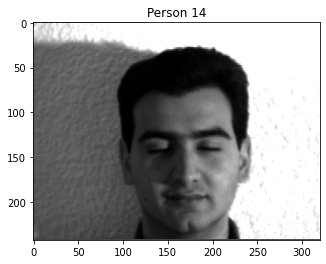

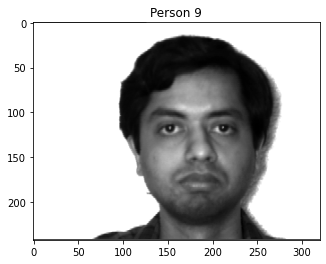

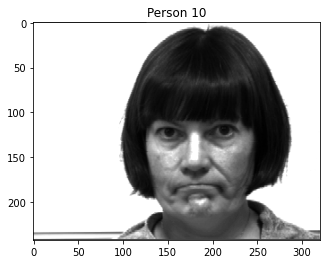

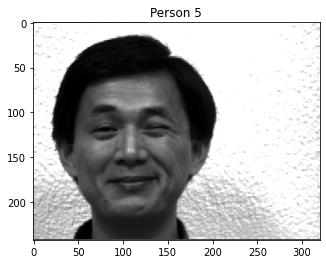

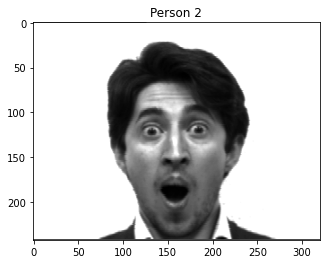

In [ ]:
sample = np.random.choice(len(data), 5, replace=False)
for i in sample:
  example = data[i]
  plt.imshow(example['img'].squeeze(0).numpy(), cmap='gray')
  plt.title("Person " + str(example['label']))
  plt.show()
  

In [ ]:
#Create dataset, apply label-preserving transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomAffine(70),
    transforms.RandomCrop(225), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomErasing(0.5),
    transforms.RandomPerspective(0.5),
])
data = YaleFacesDataset(data_dir, transform=transform)

<font color="Blue">Let's show some examples after we augment the data</font>

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


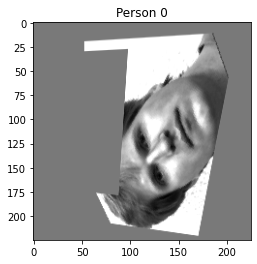

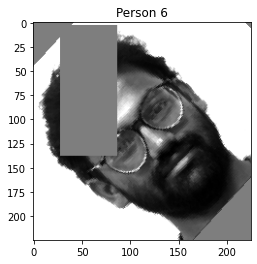

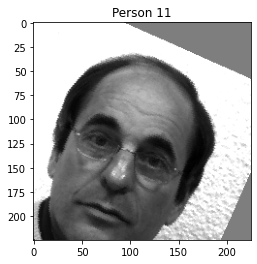

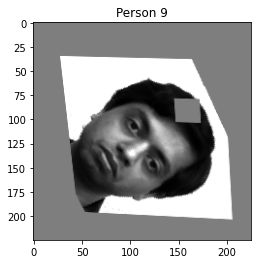

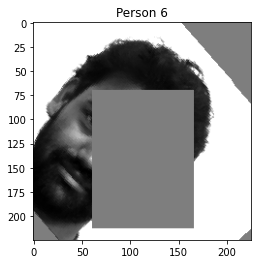

In [ ]:


sample = np.random.choice(len(data), 5, replace=False)
for i in sample:
  example = data[i]
  plt.imshow(example['img'].squeeze(0).numpy(), cmap='gray')
  plt.title("Person " + str(example['label']))
  plt.show()
  

<font color='blue'>
We can see the images look warped in many ways, but the faces are still recognizable to a human.
</font>

In [ ]:
#Caculate which person is stored in which examples
indices = {}
for i in range(15):
  indices[i] = []
for idx in range(len(data)):
  label = data[idx]['label']
  indices[label].append(idx)
np.random.seed(0)
#Make sure we can include all people in our training and test data
test_inds = []
train_inds = []
dev_inds = []
for ids in indices.values():
  keep = np.random.choice(len(ids), 2, replace=False)
  inds = set(range(len(ids)))
  test = set(keep)
  train = inds.difference(test)
  dev = np.random.choice(list(train), 2, replace=False)
  train = train.difference(set(dev))
  for x in test:
    test_inds.append(ids[x])
  for x in train:
    train_inds.append(ids[x])
  for x in dev:
    dev_inds.append(ids[x])

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


In [ ]:
#Create new train, dev, test datasets
train_data = Subset(data, train_inds)
test_data = Subset(data, test_inds)
dev_data = Subset(data, dev_inds)

In [ ]:
#Create train, dev, test loader
train_loader = DataLoader(train_data, batch_size=20, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10)
dev_loader = DataLoader(dev_data, batch_size=10)

# Models and Evaluation

### Experimental setup
Our metric to determine how well our system works is classification accuracy. This is standard in multi-class classification problems. We were planning on examining the results further using a confusion matrix to see where our model makes the most errors, however it achieved a high enough accuracy that we wouldn't learn anything valuable from that. To measure the accuracy when applying random transformations we will measure the performance on the test set over 30 iterations of data augmentation. This will give us a good idea of the average performance of the model.

To train our deep learning models, we input the raw image into our convolutional network which will output a score for every class. During training we put those scores through a softmax function and calculate the cross-entropy loss between that and a one-hot encoded vector with the true class label. To make a prediction, we take the argmax over the network output to be our class label.

For PCA, we train our model by selecting five images from each class and extracting the mean and first three principal components from these images. We then store the basis of this three dimensional subspace in a database. When we want to make a prediction, we iterate through all subspaces in our database and project this new image onto that subspace. Whichever class corresponds to the resulting vector with the greatest magnitude is the class we will predict.

### Baselines
This dataset has been "solved" already using non-deep learning based methods. Specifically, PCA based recognition has been the most popular and so we will use this as our baseline. We expect that our neural network will perform worse than PCA when our dataset has no augmentations, but will perform better when augmentations are added.

### Methods
Our first convolutional network has 7 convolutional layers whose output is flattened and fed into three fully connected feed-forward layers. In between each convolutional layer we apply a batchnorm layer and use LeakyReLU activations. After the third, fifth, and seventh layers we apply a max pooling layer to reduce the size of the images as well as aggregate important features. In between the fully connected layers we apply ReLU activations.

For our second network, we used the VGG16 model that has been pretrained on Imagenet. Our models were trained using the ADAM optimizer. We trained our models using a range of hyperparameters but we found the ones that worked best were a learning rate of 0.0001 and a batch size of 10 over 500 epochs for the randomly initialized model and 200 epochs for the pretrained model.

Batchnorm reduces internal covariate shift, while the max pooling layers teach our model to focus on the important aspects of the images that lead to better classification.

We chose Cross Entropy as our loss function because it outputs probabilities for a multi-classification problem, which was appropriate for wanting to compute the probability across all faces for our output. 

Our method for using PCA is described in the 'Experimental Setup' section but we will repeat it here. We extract the top three principal components from a set of five images from each class and use these as the basis of a three dimensional subspace. To test the accuracy of our model, we iterate through the remaining images and record the closest subspace to each new image. The class corresponding to this subspace is the class that the model will predict.

The hardest part of this procedure was tuning hyperparameters: the model would take minutes to train, so a lot of time was spent waiting for the model to finish after making small variations to our hyperparameters to see how it would do.


In [ ]:
# Convolutional block (Labeled like residual block but regular convolutional blocks worked better in this case)
class ResBlock(nn.Module):
  def __init__(self, channels, kernel_size, dilation=0):
    super(ResBlock, self).__init__()

    self.block = nn.Sequential(
        nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=kernel_size//2),
        nn.LeakyReLU(0.1),
        nn.BatchNorm2d(channels),
        nn.Conv2d(channels, channels, kernel_size=kernel_size, padding=kernel_size//2),
        nn.BatchNorm2d(channels),
        nn.LeakyReLU(0.1)
    )

  def forward(self, x):
    return self.block(x)

#Define network
class SimpleCNN(nn.Module):

  def __init__(self):
    super(SimpleCNN, self).__init__()

    self.network = nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=5),
      nn.LeakyReLU(0.1),
      nn.BatchNorm2d(32),
      nn.Conv2d(32, 64, kernel_size=5),
      nn.LeakyReLU(0.1),
      nn.BatchNorm2d(64),
      nn.Conv2d(64, 128, kernel_size=5),
      nn.LeakyReLU(0.1),
      nn.BatchNorm2d(128),
      nn.MaxPool2d(3),
      ResBlock(128, 5),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.1),
      nn.MaxPool2d(3),
      ResBlock(128, 5),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.1),
    )

    self.output_layers = nn.Sequential(
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 15)
    )
    
  def forward(self, x):
    out = self.network(x)
    out = nn.functional.max_pool2d(out, out.size()[-2:])
    out = self.output_layers(out.view(-1, 128))
    return out
    


In [ ]:
def weights_init(net):
  for i in net.modules():
    if isinstance(i, nn.Linear) or isinstance(i, nn.Conv2d):
      nn.init.kaiming_uniform_(i.weight.data)

In [ ]:
#Initialize model and weights
learning_rate = 0.0001
num_epochs = 500

net = SimpleCNN()
weights_init(net)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_metric = nn.CrossEntropyLoss()

if gpu_boole:
  net = net.cuda()

In [ ]:
#Create a function to evaluate our model performance
#Returns loss, accuracy across a dataloader
def model_eval(model, loss_metric, data_loader, eval_type='Train', verbose=True):
  total_loss = 0
  total_right = 0
  total_examples = 0
  batches = 0
  
  model.eval()
  for i, batch in enumerate(data_loader):
    images, labels = batch['img'], batch['label']
    if gpu_boole:
      images, labels = images.cuda(), labels.cuda()
    
    with torch.no_grad():
      outputs = model(images)
    loss = loss_metric(outputs, labels)
    total_loss += loss.detach()
    pred = torch.argmax(outputs, dim=1)
    right = pred == labels
    total_right += right.sum().detach()
    total_examples += len(labels)
    batches += 1
  
  accuracy = total_right.cpu().data.numpy().item() / total_examples

  if verbose:
    print(eval_type + " loss: %1.3f" %(total_loss.cpu().numpy().item() / batches))
    print(eval_type + " accuracy: %1.2f" %(accuracy))

  return total_loss.cpu().numpy().item() / batches, accuracy
    

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


Train loss: 2.983
Train accuracy: 0.08
Dev loss: 3.178
Dev accuracy: 0.03
Train loss: 1.930
Train accuracy: 0.38
Dev loss: 2.223
Dev accuracy: 0.37
Train loss: 1.202
Train accuracy: 0.63
Dev loss: 1.260
Dev accuracy: 0.67
Train loss: 0.837
Train accuracy: 0.69
Dev loss: 0.888
Dev accuracy: 0.63
Train loss: 0.472
Train accuracy: 0.85
Dev loss: 0.868
Dev accuracy: 0.63
Train loss: 0.443
Train accuracy: 0.85
Dev loss: 0.417
Dev accuracy: 0.97
Train loss: 0.364
Train accuracy: 0.91
Dev loss: 0.520
Dev accuracy: 0.83
Train loss: 0.236
Train accuracy: 0.97
Dev loss: 0.673
Dev accuracy: 0.80
Train loss: 0.295
Train accuracy: 0.92
Dev loss: 0.495
Dev accuracy: 0.90
Train loss: 0.213
Train accuracy: 0.95
Dev loss: 0.499
Dev accuracy: 0.90
Train loss: 0.227
Train accuracy: 0.94
Dev loss: 0.405
Dev accuracy: 0.87
Train loss: 0.296
Train accuracy: 0.91
Dev loss: 0.293
Dev accuracy: 0.90
Train loss: 0.238
Train accuracy: 0.92
Dev loss: 0.539
Dev accuracy: 0.87
Train loss: 0.214
Train accuracy: 0.92

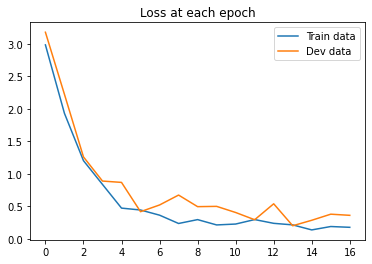

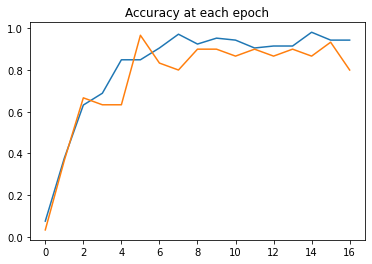

In [ ]:
#Actually train our custom model

if not os.path.isfile("models/custom1.torch"):
  train_loss_over_epochs = []
  train_accuracy_over_epochs = []
  dev_loss_over_epochs = []
  dev_accuracy_over_epochs = []

  for epoch in range(num_epochs):
    net.train()
    for i, batch in enumerate(train_loader):
      optimizer.zero_grad()
      images, labels = batch['img'], batch['label']
      if gpu_boole:
        images, labels = images.cuda(), labels.cuda()
      
      outputs = net(images)
      loss = loss_metric(outputs, labels)
      loss.backward()
      optimizer.step()

    if epoch % 30 == 0:
      train_loss, train_acc = model_eval(net, loss_metric, train_loader)
      dev_loss, dev_acc = model_eval(net, loss_metric, dev_loader, eval_type="Dev")
      train_loss_over_epochs.append(train_loss)
      train_accuracy_over_epochs.append(train_acc)
      dev_loss_over_epochs.append(dev_loss)
      dev_accuracy_over_epochs.append(dev_acc)

plt.plot(train_loss_over_epochs, label="Train data")
plt.plot(dev_loss_over_epochs, label="Dev data")
plt.title("Loss at each epoch")
plt.legend()
plt.savefig("Custom_loss.png")
plt.show()
plt.plot(train_accuracy_over_epochs, label="Train data")
plt.plot(dev_accuracy_over_epochs, label="Dev data")
plt.title("Accuracy at each epoch")
plt.savefig("Custom_acc.png")
torch.save(net, "models/custom1.torch")

In [ ]:
net = torch.load("models/custom1.torch")

In [ ]:
total = 0
N = 0
#Here's how we did on the test set with augmentations
for i in range(30):
  with torch.no_grad():
    loss, acc = model_eval(net, loss_metric, test_loader, eval_type="Test", verbose=False)
    total += acc
    N += 1
print(f'Accuracy: {total / N}')

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


Accuracy: 0.8377777777777777


In [ ]:
#Un-augmented dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

data = YaleFacesDataset(data_dir, transform=transform)
test_set = Subset(data, test_inds)
test_loader = DataLoader(test_set, batch_size=10)

In [ ]:
#Here's how we did on the set with no augmentations
acc, loss = model_eval(net, loss_metric, test_loader, eval_type="Test")

Test loss: 0.404
Test accuracy: 0.87


In [ ]:
#Let's try a second model, pretrained on imagenet
net = torch.hub.load('pytorch/vision:v0.6.0', 'vgg16', pretrained=True)
net.classifier[6] = nn.Linear(4096, 15)
nn.init.kaiming_uniform_(net.classifier[6].weight.data)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


tensor([[ 0.0149, -0.0055, -0.0209,  ...,  0.0180,  0.0229,  0.0280],
        [ 0.0122,  0.0341,  0.0265,  ..., -0.0273, -0.0121,  0.0366],
        [-0.0155,  0.0179,  0.0358,  ...,  0.0336,  0.0370, -0.0210],
        ...,
        [-0.0171,  0.0365, -0.0101,  ...,  0.0044, -0.0082, -0.0070],
        [-0.0146, -0.0263,  0.0270,  ...,  0.0362,  0.0326, -0.0032],
        [ 0.0368,  0.0351, -0.0057,  ..., -0.0351,  0.0210,  0.0286]])

In [ ]:
num_epochs = 200
learning_rate = 0.0001

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_metric = nn.CrossEntropyLoss()

if gpu_boole:
  net = net.cuda()

In [ ]:
#New model eval function to handle 3 channel inputs
def model_eval(model, loss_metric, data_loader, eval_type='Train', verbose=True):
  total_loss = 0
  total_right = 0
  total_examples = 0
  batches = 0
  
  model.eval()
  for i, batch in enumerate(data_loader):
    images, labels = batch['img'], batch['label']
    images = images.repeat(1, 3, 1, 1)
    if gpu_boole:
      images, labels = images.cuda(), labels.cuda()
    
    with torch.no_grad():
      outputs = model(images)
    loss = loss_metric(outputs, labels)
    total_loss += loss.detach()
    pred = torch.argmax(outputs, dim=1)
    right = pred == labels
    total_right += right.sum().detach()
    total_examples += len(labels)
    batches += 1
  
  accuracy = total_right.cpu().data.numpy().item() / total_examples

  if verbose:
    print(eval_type + " loss: %1.3f" %(total_loss.cpu().numpy().item() / batches))
    print(eval_type + " accuracy: %1.2f" %(accuracy))

  return total_loss.cpu().numpy().item() / batches, accuracy
    

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


Train loss: 2.715
Train accuracy: 0.09
Dev loss: 2.692
Dev accuracy: 0.07
Dev loss: 0.883
Dev accuracy: 0.70
Train loss: 0.358
Train accuracy: 0.89
Dev loss: 0.315
Dev accuracy: 0.87
Train loss: 0.272
Train accuracy: 0.90
Dev loss: 0.344
Dev accuracy: 0.93
Train loss: 0.095
Train accuracy: 0.96
Dev loss: 0.181
Dev accuracy: 0.87
Train loss: 0.124
Train accuracy: 0.94
Dev loss: 0.583
Dev accuracy: 0.93
Train loss: 0.216
Train accuracy: 0.92
Dev loss: 0.204
Dev accuracy: 0.97


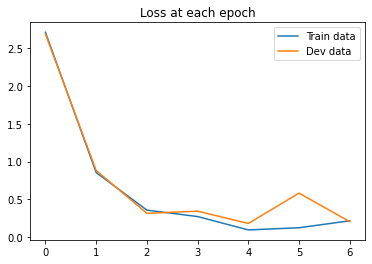

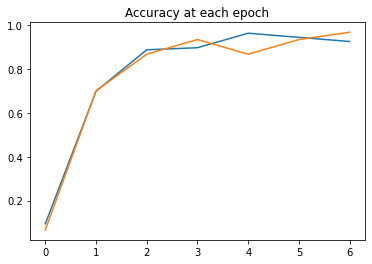

In [ ]:
#Actually train our custom model

if not os.path.isfile("models/pretrained1.torch"):
  train_loss_over_epochs = []
  train_accuracy_over_epochs = []
  dev_loss_over_epochs = []
  dev_accuracy_over_epochs = []


  for epoch in range(num_epochs):
    net.train()

    for i, batch in enumerate(train_loader):

      optimizer.zero_grad()
      images, labels = batch['img'], batch['label']
      images = images.repeat(1, 3, 1, 1)
      if gpu_boole:
        images, labels = images.cuda(), labels.cuda()
        
      outputs = net(images)
      loss = loss_metric(outputs, labels)
      loss.backward()
      optimizer.step()

    if epoch % 30 == 0:
      train_loss, train_acc = model_eval(net, loss_metric, train_loader)
      dev_loss, dev_acc = model_eval(net, loss_metric, dev_loader, eval_type="Dev")
      train_loss_over_epochs.append(train_loss)
      train_accuracy_over_epochs.append(train_acc)
      dev_loss_over_epochs.append(dev_loss)
      dev_accuracy_over_epochs.append(dev_acc)

plt.plot(train_loss_over_epochs, label="Train data")
plt.plot(dev_loss_over_epochs, label="Dev data")
plt.title("Loss at each epoch")
plt.legend()
plt.savefig("Pretrained_loss.png")
plt.show()
plt.plot(train_accuracy_over_epochs, label="Train data")
plt.plot(dev_accuracy_over_epochs, label="Dev data")
plt.title("Accuracy at each epoch")
plt.savefig("Pretrained_acc.png")
torch.save(net, "models/pretrained1.torch")

In [ ]:
net = torch.load("models/pretrained1.torch")

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomAffine(70),
    transforms.RandomCrop(225), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomErasing(0.5),
    transforms.RandomPerspective(0.5),
])
data = YaleFacesDataset(data_dir, transform=transform)
test_data = Subset(data, test_inds)
test_loader = DataLoader(test_set, batch_size=10)

In [ ]:
total = 0
N = 0
#Here's how we did on the test set with augmentations
for i in range(30):
  with torch.no_grad():
    loss, acc = model_eval(net, loss_metric, test_loader, eval_type="Test", verbose=False)
    total += acc
    N += 1
print(f'Accuracy: {total / N}')

Accuracy: 0.966666666666666


In [ ]:
#Un-augmented dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])
data = YaleFacesDataset(data_dir, transform=transform)

test_set = Subset(data, test_inds)

test_loader = DataLoader(test_set, batch_size=10)

In [ ]:
#Here's how we did on the set with no augmentations
acc, loss = model_eval(net, loss_metric, test_loader, eval_type="Test")

Test loss: 0.072
Test accuracy: 0.97


Implementation of PCA methods

In [ ]:
# X a DxN array, d the dimension of the subspace
#Returns mu = 1xD average of the data,
# U = Dxd low dimensional basis,
# Y = dxN low dimensional coordinates
def pca(X, d):
    avg = np.mean(X, axis = 1, keepdims=True)
    centered = X - avg.reshape(X.shape[0], 1)
    U, S, Vt = np.linalg.svd(centered, full_matrices=False)
    Y = np.diag(S[0:d]) @ Vt[0:d, :]
    return avg, U[:, 0:d], Y

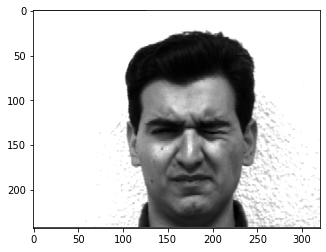

In [ ]:
# Sample image
test_image = None
for filename in os.listdir(data_dir):
  test_image = io.imread(os.path.join(data_dir, filename))
plt.imshow(test_image, cmap='gray')
N, M = test_image.shape

<font color="Blue">Vectorize all images and store them according to class.</font>

In [ ]:
people = {}
for filename in os.listdir(data_dir):
  label = filename[-2:]
  #set_trace()

  person = io.imread(os.path.join(data_dir, filename)).reshape(-1, 1)
  if int(label) in people.keys():
    people[int(label)].append(person)
  else:
    people[int(label)] = [person]

<font color="Blue">Extract low dimensional subspace from each class</font>

In [ ]:
subspaces = {}
for person, images in people.items():
  training_ims = np.concatenate(images[:5], axis=1)
  mu, U, Y = pca(training_ims, 3)
  subspaces[person] = (mu, U)  

In [ ]:
# This function matches an image to the closest subspace
def predict_face(image):
  highest_match = 0
  pred = None
  for face, subspace in subspaces.items():
    mu, U = subspace
    projection = (image - mu).T @ U
    mag = np.linalg.norm(projection)
    if mag > highest_match:
      highest_match = mag
      pred = face
  return person

In [ ]:
#With no augmentatinons, PCA gives us 100% accuracy, better than our deep learning model, but is it generalizable?
correct = 0
total = 0
for person, images in people.items():
  for im in images[5:]:
    prediction = predict_face(im)
    if prediction == person:
      correct += 1
    total += 1
print(correct / total)

1.0


In [ ]:
#What if we perform augmentations on the images?
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomAffine(70),
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.RandomErasing(0.5),
     transforms.RandomPerspective(0.5)]
)
correct = 0
total = 0
for person, images in people.items():
  for im in images[5:]:
    #set_trace()
    im = transform(im.reshape(N, M))
    im = im.squeeze(0).numpy().reshape(-1, 1)
    prediction = predict_face(im)
    if prediction == person:
      correct += 1
    total += 1
print(correct / total)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


1.0


# Results
We measured our accuracies on the augmented and un-augmented datasets The accuracies were as follows:

<li>PCA: 1.0</li>
<li>PCA w/augmentation: 1.0</li>
<li>Pretrained model: 0.97</li>
<li>Pretrained model w/augmentations: 0.96</li>
<li>Custom model: 0.85</li>
<li>Custom model w/augmentations: 0.83</li>

The training and accuracy plots of our neural networks are shown below. The units on the x axis are epochs/30


Accuracy and loss for custom model


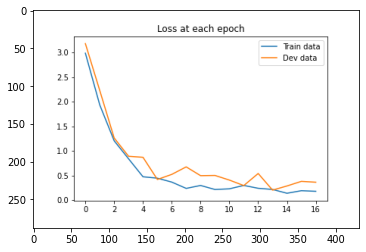

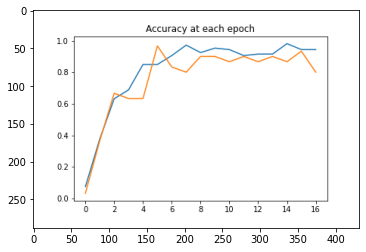

In [ ]:
print("Accuracy and loss for custom model")
plot = io.imread("Custom_loss.png")
plt.imshow(plot)
plt.show()
plot = io.imread("Custom_acc.png")
plt.imshow(plot)
plt.show()

Accuracy and loss for pretrained model


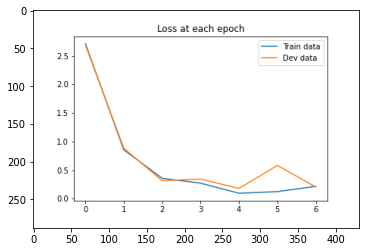

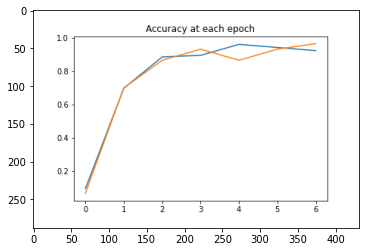

In [ ]:
print("Accuracy and loss for pretrained model")
plot = io.imread("Pretrained_loss.png")
plt.imshow(plot)
plt.show()
plot = io.imread("Pretrained_acc.png")
plt.imshow(plot)
plt.show()

# Discussion
As we expected, our pretrained model outperformed our model that was trained on our dataset alone, and this model achieves an accuracy of 97%, which is very close to the results of PCA. This model also converged about three times faster than our previous model, which is another benefit of using pretraining. 

For our future ML projects, we now understand how important it is to have a baseline. If you are working on improving certain ML methods, it can inform you of how well current research performs on your problem, and how you can build on those methods to achieve better performance. (It also occasionally, as it did in our case, tells us that there are quite robust methods out there that can perform well on our task!)

One of the most surprising things we found while doing this project was that our PCA method was able to still give correct predictions with augmentations when we thought it wouldn’t since PCA typically performs worse on augmented images than deep learning does. This may be due to the fact that this dataset does not have many classes and so the subspaces can remain distinct from each other even in the presence of perturbations. This might be different if we had thousands of classes, but it would require additional testing to verify.

If we had two more weeks to work on this project we could have also trained models on larger datasets than Yale Faces to see how our model architecture would do with more data. This would also have given us a chance to figure out how to process data with imbalanced classes and/or missing data.
